In [3]:
#Importamos librerías y visualizamos el dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf


file = '78946.csv'

df = pd.read_csv(file, sep=';', encoding="latin-1")
df.head()

,Actividades según jerarquía (CNAE-2009),Índice y tasas,Periodo,Total
0,Comercio al por menor sin Estaciones de Servic...,Índice,2025M11,"111,675"
1,Comercio al por menor sin Estaciones de Servic...,Índice,2025M10,"111,412"
2,Comercio al por menor sin Estaciones de Servic...,Índice,2025M09,"109,943"
3,Comercio al por menor sin Estaciones de Servic...,Índice,2025M08,"109,295"
4,Comercio al por menor sin Estaciones de Servic...,Índice,2025M07,"119,610"


**************************************

### PUNTO 2

Creamos la representación gráfica del dataset y descomponemos para visualizar estacionalidad

In [4]:
##Convertimos la columna Periodo a Datetime
df["Periodo"] = pd.to_datetime(df["Periodo"], format='%YM%m')

##Ordenamos los valores por fecha
df = df.sort_values('Periodo')

##Establecemos la fecha como índice
df.set_index ('Periodo',inplace=True)

#Convertimos los valores del índice a número
df["Total"] = df["Total"].str.replace(",",".").astype(float)

#Visualizamos los cambios
df.head()

,Actividades según jerarquía (CNAE-2009),Índice y tasas,Total
Periodo,,,
2000-01-01,Comercio al por menor sin Estaciones de Servic...,Índice,106.466
2000-02-01,Comercio al por menor sin Estaciones de Servic...,Índice,91.623
2000-03-01,Comercio al por menor sin Estaciones de Servic...,Índice,100.578
2000-04-01,Comercio al por menor sin Estaciones de Servic...,Índice,98.013
2000-05-01,Comercio al por menor sin Estaciones de Servic...,Índice,102.693


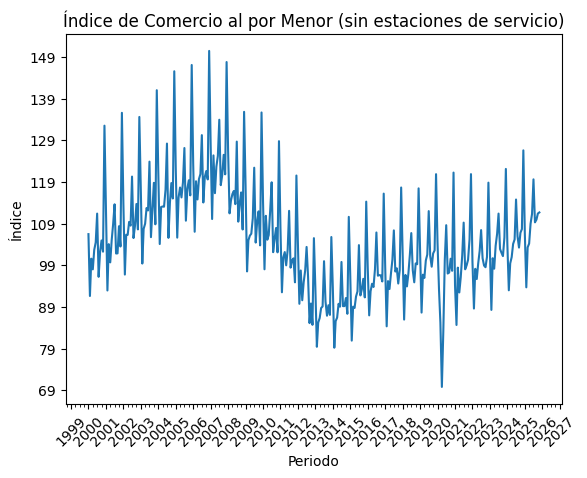

In [6]:
#Creamos intervalos y visualizamos los datos

plt.figure()
plt.plot(df.index,df['Total'])
plt.title("Índice de Comercio al por Menor (sin estaciones de servicio)")
plt.xlabel("Periodo")
plt.ylabel("Índice")

#Creamos intervalos para la columna periodo
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # tick cada año
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # mostrar año
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1,4,7,10)))  # ticks menores

#Creamos intervalos para la columna Total
y_min = int(df['Total'].min())
y_max = int(df['Total'].max())
plt.yticks(np.arange(y_min, y_max + 1, step=10))

plt.xticks(rotation=45)

plt.show()

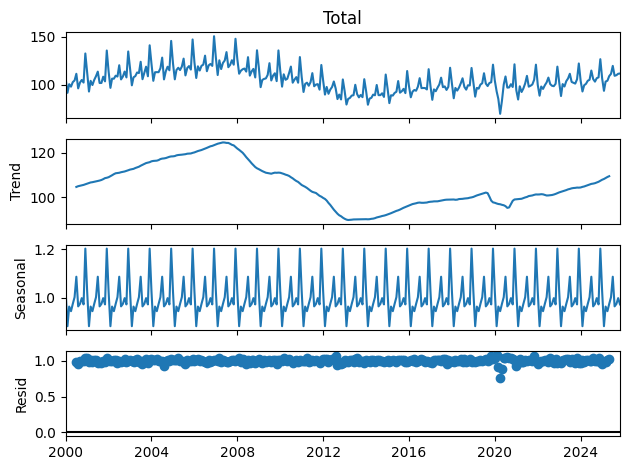

In [7]:
#Procedemos con la descomposición de la serie temporal

# Utilizamos descomposición multiplicativa
decomposition = seasonal_decompose(df['Total'], model='multiplicative', period=12)

# Graficamos
decomposition.plot()
plt.tight_layout()
plt.show()

*******************************************

### Punto 3

Dividimos el dataset entre Test y Train

In [8]:
#Reservamos 10 observaciones para comprobar la eficacia de los modelos a construir

n_test = 10

train = df[:-n_test]
test = df[-n_test:]

*************************************************************************************

### PUNTO 4

Probamos diversos modelos de suavizado exponencial

In [9]:
#Establecemos la frecuencia como MS para train

train = train.asfreq("MS")

# --- Utilizando SES ---
model_ses = SimpleExpSmoothing(train['Total']).fit()

# --- Utilizando Holt ---
model_holt = ExponentialSmoothing(
    train['Total'],
    trend='add',
    seasonal=None
).fit()

# --- Utilizando Holt-Winters aditivo---
model_hw_add = ExponentialSmoothing(
    train['Total'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

# --- Utilizando Holt-Winters multiplicativo ---
model_hw_mul = ExponentialSmoothing(
    train['Total'],
    trend='add',
    seasonal='mul',
    seasonal_periods=12
).fit()

In [10]:
#Evaluamos los modelos anteriores utilizando MAE y RMSE

# Fijamos el periodo futuro en una longitud igual a la longitud del test
h = len(test)

pred_ses = model_ses.forecast(h)
pred_holt = model_holt.forecast(h)
pred_hw_add = model_hw_add.forecast(h)
pred_hw_mul = model_hw_mul.forecast(h)

# Calculamos métricas
def evaluar_modelo(nombre, pred):
    mae = mean_absolute_error(test['Total'], pred)
    rmse = np.sqrt(mean_squared_error(test['Total'], pred))
    return [nombre, mae, rmse]

resultados = pd.DataFrame([
    evaluar_modelo("SES", pred_ses),
    evaluar_modelo("Holt", pred_holt),
    evaluar_modelo("HW Aditivo", pred_hw_add),
    evaluar_modelo("HW Multiplicativo", pred_hw_mul)
], columns=["Modelo", "MAE", "RMSE"])


#Visualizamos los resultados
resultados


,Modelo,MAE,RMSE
0,SES,4.948856,6.476559
1,Holt,4.216349,6.236822
2,HW Aditivo,2.967027,3.273195
3,HW Multiplicativo,3.245457,3.719490


* Resultado:
Con base en los datos de la tabla anterior se define *HW Aditivo* como el mejor modelo para la serie temporal en estudio

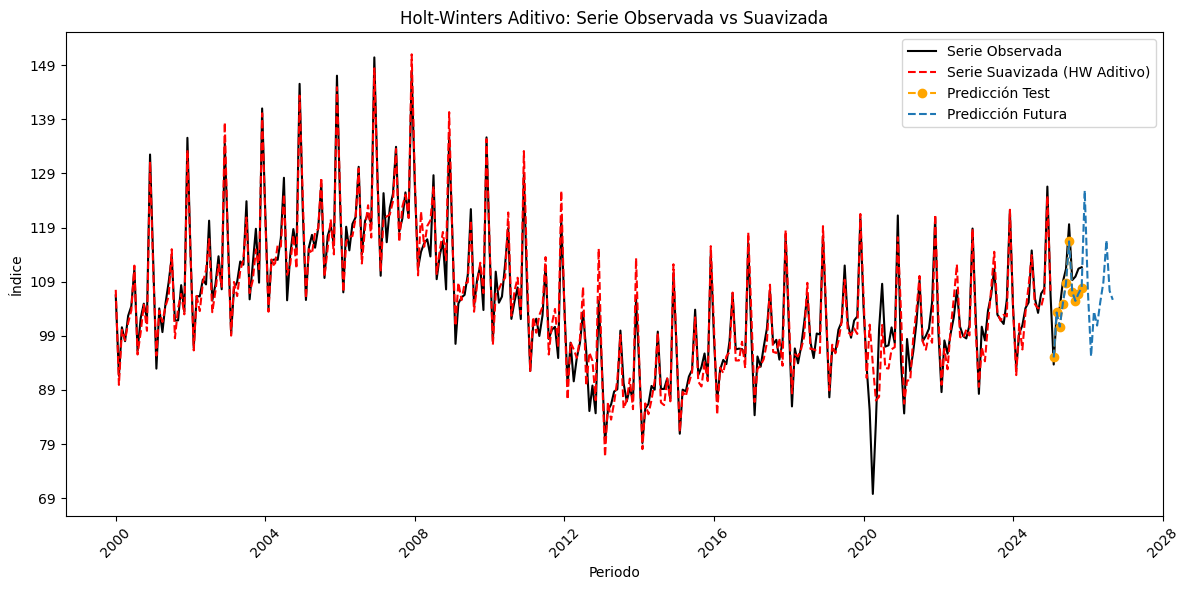

In [11]:
#Visualizamos las series temporales observada y suavizada para el modelo ganador

# serie suavizada dentro del train
fitted_values = model_hw_add.fittedvalues

# Predicción sobre test
h = len(test)
forecast_test = model_hw_add.forecast(h)

plt.figure(figsize=(12,6))

# Serie observada 
plt.plot(df.index, df['Total'], label='Serie Observada', color='black')

# Serie suavizada (solo train)
plt.plot(train.index, fitted_values, 
         label='Serie Suavizada (HW Aditivo)', 
         linestyle='--', color='red')

# Predicción sobre test
plt.plot(test.index, forecast_test, 
         label='Predicción Test', 
         linestyle='--', marker='o', color='orange')

# Creamos intervalos para los valores del índice
y_min = int(df['Total'].min())
y_max = int(df['Total'].max())
plt.yticks(np.arange(y_min, y_max + 1, step=10))

# Predicción adicional futura (10 meses)
forecast_future = model_hw_add.forecast(h + 10)

plt.plot(forecast_future.index, forecast_future, 
         label='Predicción Futura', 
         linestyle='--')

plt.title("Holt-Winters Aditivo: Serie Observada vs Suavizada")
plt.xlabel("Periodo")
plt.ylabel("Índice")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

***************************************************

### Punto 5

Representamos series y ajustamos

In [12]:
model_hw_add.params

{'smoothing_level': np.float64(0.3897404005679374),
 'smoothing_trend': np.float64(0.0),
 'smoothing_seasonal': np.float64(0.230014919738576),
 'damping_trend': nan,
 'initial_level': np.float64(102.66410580111906),
 'initial_trend': np.float64(0.016043774631676118),
 'initial_seasons': array([  4.81860856, -12.35643481,  -2.85546607,  -4.97149618,
         -1.7069513 ,   0.05901117,   8.01786064,  -8.19110655,
         -4.30360031,  -0.29610574,  -5.20228025,  25.1361716 ]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [121]:
# Diferenciación regular
diff_1 = train['Total'].diff().dropna()

# Diferenciación estacional (periodo 12)
diff_seasonal = diff_1.diff(12).dropna()


<Figure size 640x480 with 0 Axes>

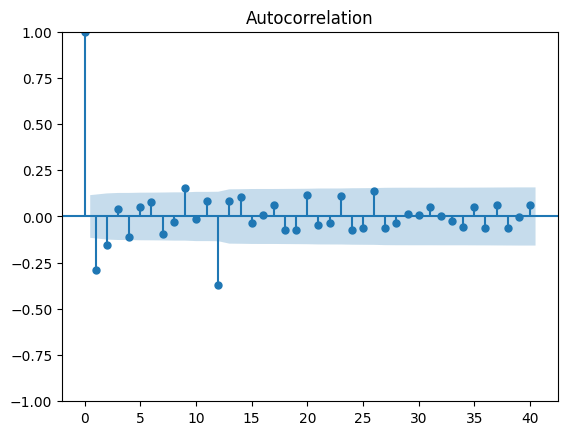

<Figure size 640x480 with 0 Axes>

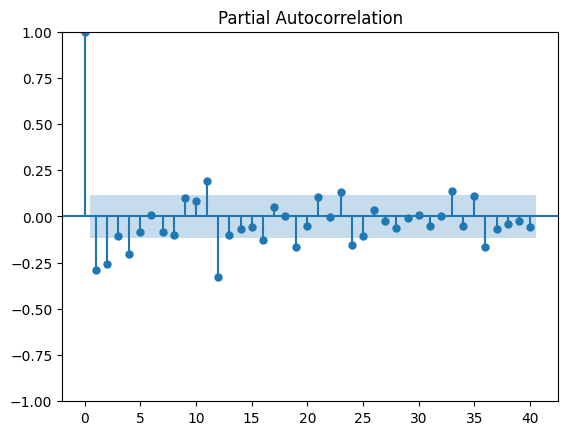

In [122]:
plt.figure()
plot_acf(diff_seasonal, lags=40)
plt.show()

plt.figure()
plot_pacf(diff_seasonal, lags=40)
plt.show()

In [123]:
#Especificamos el modelo

model_sarima = SARIMAX(
    train['Total'],
    order=(0,1,1),
    seasonal_order=(0,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_sarima = model_sarima.fit()

print(results_sarima.summary())


                                     SARIMAX Results                                      
Dep. Variable:                              Total   No. Observations:                  301
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -711.925
Date:                            Thu, 19 Feb 2026   AIC                           1429.850
Time:                                    08:54:27   BIC                           1440.689
Sample:                                01-01-2000   HQIC                          1434.200
                                     - 01-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5461      0.025    -21.480      0.000      -0.596      -0.496
ma.S.L12      -0.6980      0.042   

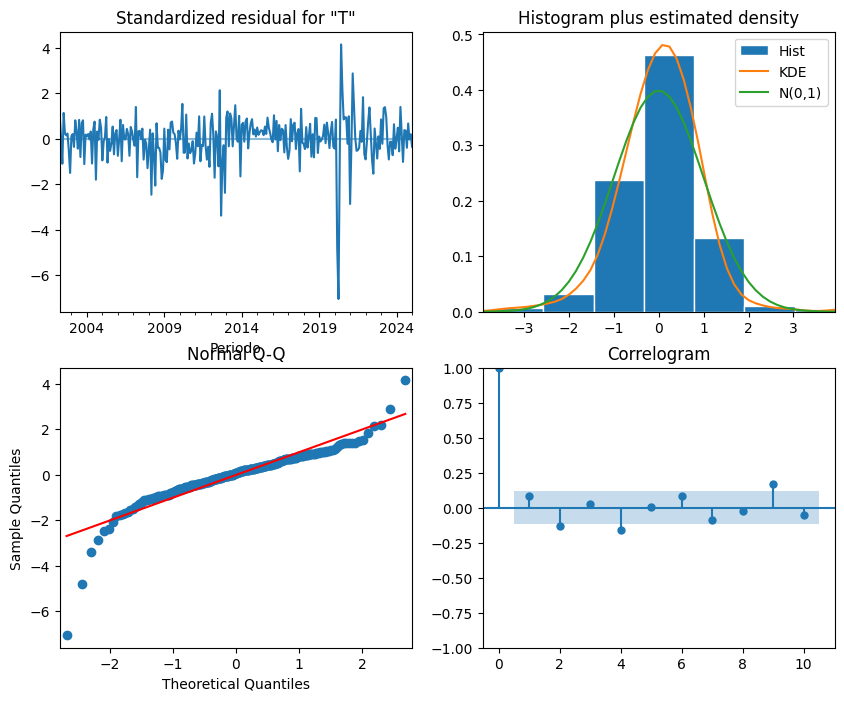

In [124]:
results_sarima.plot_diagnostics(figsize=(10,8))
plt.show()

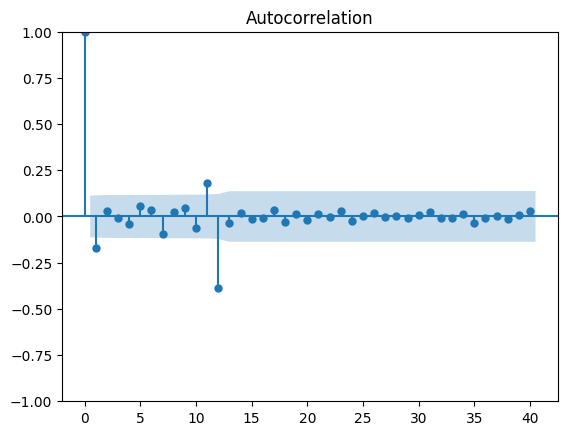

In [125]:
plot_acf(results_sarima.resid, lags=40)
plt.show()

******************************************************

## Punto 6

Escribimos la expresión algebraica del modelo ajustado

(1−B)(1−B12)yt​=(1−θ1​B)(1−Θ1​B12)εt​

****************************************************

### PUNTO 7

Calculamos predicciones e intervalos de confianza

In [126]:
#Realizamos las predicciones
steps = 12

forecast = results_sarima.get_forecast(steps=steps)

pred_mean = forecast.predicted_mean
pred_ci = forecast.conf_int()


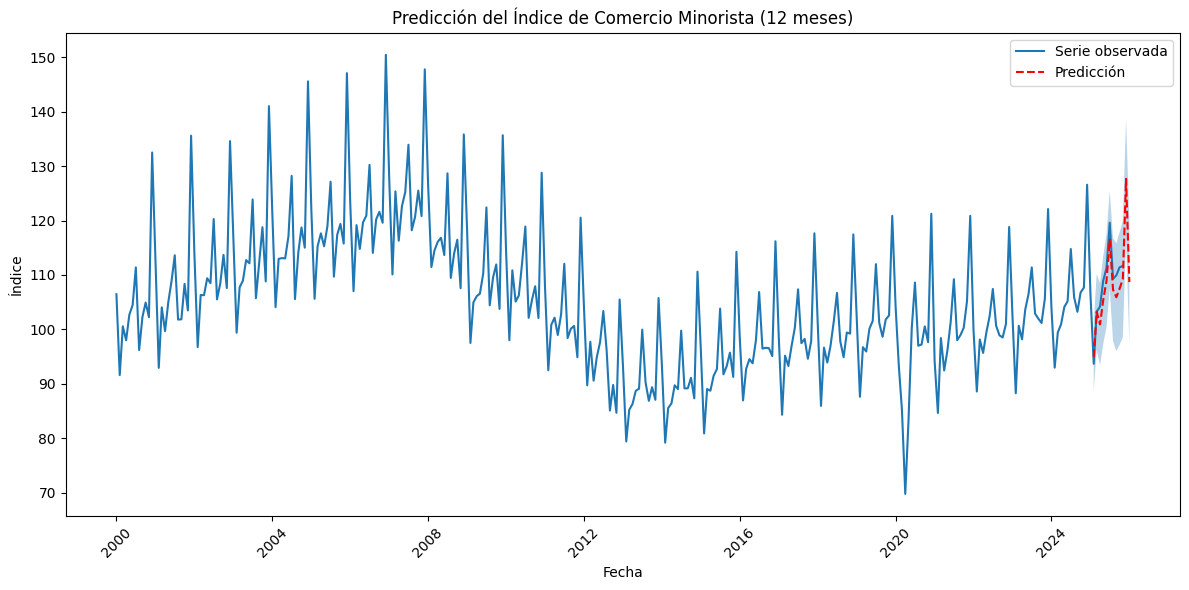

In [129]:
plt.figure(figsize=(12,6))

# Serie histórica completa
plt.plot(df['Total'], label='Serie observada')

# Predicción
plt.plot(pred_mean, label='Predicción', linestyle='--', color="red")

# Intervalo de confianza
plt.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1],
                 alpha=0.3)

plt.title("Predicción del Índice de Comercio Minorista (12 meses)")
plt.xlabel("Fecha")
plt.ylabel("Índice")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**********************************************

## PUNTO 8

Realizamos predicciones sobre los datos reservados al inicio y las comparamos tanto numérica como gráficamente

In [130]:
ses = ExponentialSmoothing(train['Total']).fit()
pred_ses = ses.forecast(10)

holt = ExponentialSmoothing(train['Total'], trend='add').fit()
pred_holt = holt.forecast(10)

hw_add = ExponentialSmoothing(
    train['Total'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

pred_hw_add = hw_add.forecast(10)

hw_mul = ExponentialSmoothing(
    train['Total'],
    trend='add',
    seasonal='mul',
    seasonal_periods=12
).fit()

pred_hw_mul = hw_mul.forecast(10)


In [131]:
#Realizamos la comparación numérica

def evaluar(real, pred):
    mae = mean_absolute_error(real, pred)
    rmse = np.sqrt(mean_squared_error(real, pred))
    return mae, rmse

resultados = []

for nombre, pred in [
    ("SES", pred_ses),
    ("Holt", pred_holt),
    ("HW Aditivo", pred_hw_add),
    ("HW Multiplicativo", pred_hw_mul)
]:
    mae, rmse = evaluar(test['Total'], pred)
    resultados.append([nombre, mae, rmse])


tabla_resultados = pd.DataFrame(resultados, columns=["Modelo", "MAE", "RMSE"])
tabla_resultados

,Modelo,MAE,RMSE
0,SES,4.938509,6.474799
1,Holt,4.216349,6.236822
2,HW Aditivo,2.967027,3.273195
3,HW Multiplicativo,3.245457,3.719490


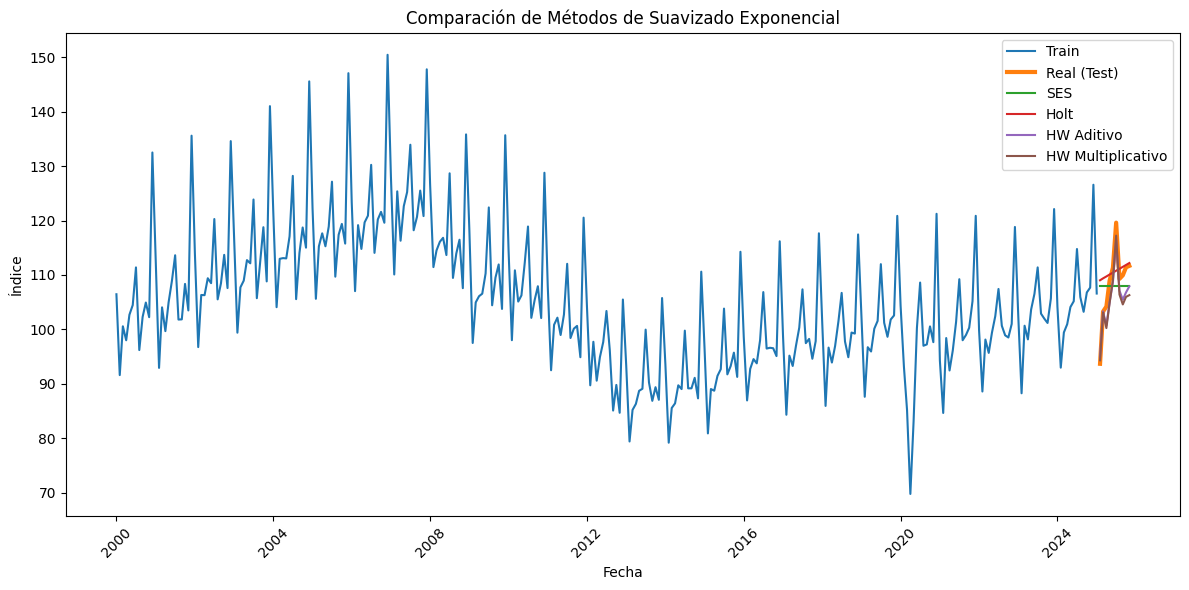

In [132]:
#Realizamos la comparación gráfica

plt.figure(figsize=(12,6))

plt.plot(train.index, train['Total'], label="Train")
plt.plot(test.index, test['Total'], label="Real (Test)", linewidth=3)

plt.plot(test.index, pred_ses, label="SES")
plt.plot(test.index, pred_holt, label="Holt")
plt.plot(test.index, pred_hw_add, label="HW Aditivo")
plt.plot(test.index, pred_hw_mul, label="HW Multiplicativo")

plt.title("Comparación de Métodos de Suavizado Exponencial")
plt.xlabel("Fecha")
plt.ylabel("Índice")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**********

## CONCLUSIONES

📌 Conclusiones Generales

El presente trabajo ha analizado la serie temporal mensual del Índice de Comercio al por menor sin estaciones de servicio (INE) con el objetivo de modelar su comportamiento y generar predicciones fiables para apoyo a la toma de decisiones.

1️⃣ Comportamiento estructural de la serie

El análisis exploratorio y la descomposición mostraron que la serie presenta:

📈 Tendencia creciente a largo plazo.

🔁 Estacionalidad anual claramente marcada (periodicidad 12).

⚠️ Perturbaciones excepcionales en 2020 asociadas al impacto económico del COVID-19.

Tras aplicar diferenciación regular y estacional, se logró obtener una serie estacionaria apta para modelización ARIMA.

2️⃣ Comparación de modelos de suavizado exponencial

Se evaluaron cuatro métodos:

Suavizado Exponencial Simple (SES)

Holt

Holt-Winters Aditivo

Holt-Winters Multiplicativo

La validación fuera de muestra (últimas 10 observaciones reservadas) mostró que:

El modelo Holt-Winters Aditivo obtuvo los menores valores de MAE y RMSE.

La estacionalidad del índice presenta amplitud aproximadamente constante, lo que justifica la superioridad del modelo aditivo frente al multiplicativo.

Este resultado demuestra la importancia de capturar correctamente la estructura estacional para mejorar la precisión predictiva.

3️⃣ Modelización SARIMA

A partir del análisis ACF y PACF se identificó un modelo:

𝑆
𝐴
𝑅
𝐼
𝑀
𝐴
(
0
,
1
,
1
)
(
0
,
1
,
1
)
12
SARIMA(0,1,1)(0,1,1)
12
	​


El modelo presentó:

Parámetros estadísticamente significativos.

Residuos compatibles con ruido blanco.

Buen ajuste estructural.

Capacidad predictiva coherente con la dinámica histórica.

El diagnóstico confirmó la idoneidad del modelo al no observar autocorrelación residual significativa.

4️⃣ Predicciones e intervalos de confianza

Se generaron predicciones para los siguientes 12 meses, justificadas por la necesidad de cubrir un ciclo estacional completo.

Los resultados muestran:

Mantenimiento del patrón estacional.

Incremento progresivo de la incertidumbre conforme aumenta el horizonte temporal.

Capacidad del modelo para generar escenarios optimista y conservador mediante intervalos de confianza.

5️⃣ Implicaciones desde el punto de vista empresarial

El análisis realizado permite:

📦 Planificar inventarios con base en demanda esperada.

📊 Ajustar presupuestos y previsiones financieras.

📅 Diseñar campañas comerciales alineadas con picos estacionales.

⚠️ Evaluar riesgos mediante escenarios probabilísticos.

La validación fuera de muestra aporta robustez al modelo y reduce el riesgo de sobreajuste, garantizando mayor confiabilidad en la toma de decisiones estratégicas.

6️⃣ Limitaciones del estudio

La presencia de shocks externos (COVID-19) introduce volatilidad difícil de capturar con modelos puramente autoregresivos.

No se han incorporado variables explicativas externas (modelos SARIMAX).

El análisis se basa exclusivamente en la dinámica histórica de la serie.

7️⃣ Conclusión final

El estudio demuestra que el Índice de Comercio Minorista presenta una estructura estable de tendencia y estacionalidad anual que puede ser modelada eficazmente mediante técnicas de suavizado exponencial y modelos SARIMA.

Entre los modelos evaluados, el Holt-Winters Aditivo y el SARIMA(0,1,1)(0,1,1)₁₂ ofrecen un equilibrio adecuado entre precisión, interpretabilidad y capacidad predictiva.

Desde una perspectiva empresarial, el modelo seleccionado constituye una herramienta válida para apoyar la planificación estratégica y la gestión del riesgo en el sector minorista.